In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [2]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
X.shape

(150, 4)

## Perform PCA with k=2

In [4]:
np.random.seed(42)
pca = PCA(n_components=2, svd_solver='covariance_eigh')
X_pca = pca.fit_transform(X)

In [5]:
X_pca.shape

(150, 2)

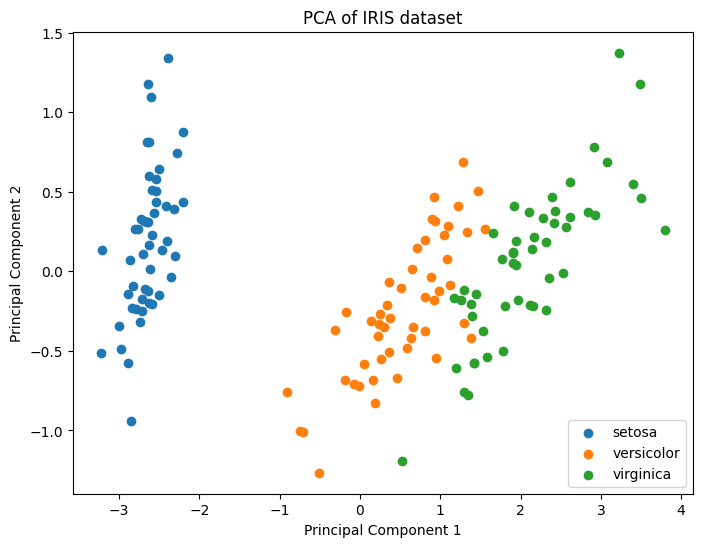

In [6]:
# Plot the features outputted by PCA
plt.figure(figsize=(8, 6))
for target in set(y):
    plt.scatter(X_pca[y == target, 0], X_pca[y == target, 1], label=iris.target_names[target])

plt.title('PCA of IRIS dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## Write PCA from scratch

We will subtract 1st eigen vectro from the initial vector and continue to find the 2nd eigen vector

In [7]:
X.shape

(150, 4)

In [8]:
col_means = X.mean(axis=0)
x_hat = X - col_means

In [9]:
num_rows = x_hat.shape[0]

In [10]:
cov_mat = (x_hat.T @ x_hat) / (num_rows - 1)
cov_mat.shape

(4, 4)

In [11]:
cov_mat

array([[ 0.68569351, -0.042434  ,  1.27431544,  0.51627069],
       [-0.042434  ,  0.18997942, -0.32965638, -0.12163937],
       [ 1.27431544, -0.32965638,  3.11627785,  1.2956094 ],
       [ 0.51627069, -0.12163937,  1.2956094 ,  0.58100626]])

In [12]:
def subtract_projections(vector: np.array, eigen_mat: np.ndarray) -> np.array:
    """
    Outputs a vector with eliminated projections into eigen_mat columns. 
     
    Args:
        vector: unit length vector
        eigen_mat: contains unit length vectors in columns dimension

    Returns:
        new vector
    """
    assert eigen_mat.shape[0] == eigen_mat.shape[0], f"Vector sizes does not match"
    cos_theta = vector @ eigen_mat  # gives cosines of angles between vectors, as all of them have unit length
    vec_projections = eigen_mat @ np.diag(cos_theta)
    for i in range(vec_projections.shape[1]):
        vector = vector - vec_projections[:, i]
    vector = vector / np.linalg.norm(vector)
    return vector


def get_eigen_vecs(matrix: np.ndarray, k: int = 2) -> np.ndarray:
    iterations = 1_000
    rand_vec = np.random.randn(matrix.shape[1])
    rand_vec = rand_vec / np.linalg.norm(rand_vec)
    eigen_vecs = np.zeros((matrix.shape[1], k), dtype=np.float64)
    
    for i in tqdm(range(k)):
        init_vec = rand_vec.copy()
        for _ in tqdm(range(iterations)):
            init_vec = matrix @ init_vec
            init_vec = init_vec / np.linalg.norm(init_vec)
            init_vec = subtract_projections(init_vec, eigen_vecs)
    
        eigen_vecs[:, i] = init_vec
    return eigen_vecs

In [13]:
np.random.seed(42)
eigen_vecs = get_eigen_vecs(cov_mat, k=2)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
eigen_vecs

array([[ 0.36138659, -0.65658877],
       [-0.08452251, -0.73016143],
       [ 0.85667061,  0.17337266],
       [ 0.3582892 ,  0.07548102]])

In [15]:
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
assert np.allclose(eigenvectors[:, :2], eigen_vecs), "Values are not close enough!"

In [16]:
# do pca
new_data = x_hat @ eigen_vecs
# Below code will give you the same results
# new_data = X @ (eigen_vecs)
# new_data = new_data - (col_means.reshape(1, -1) @ eigen_vecs)

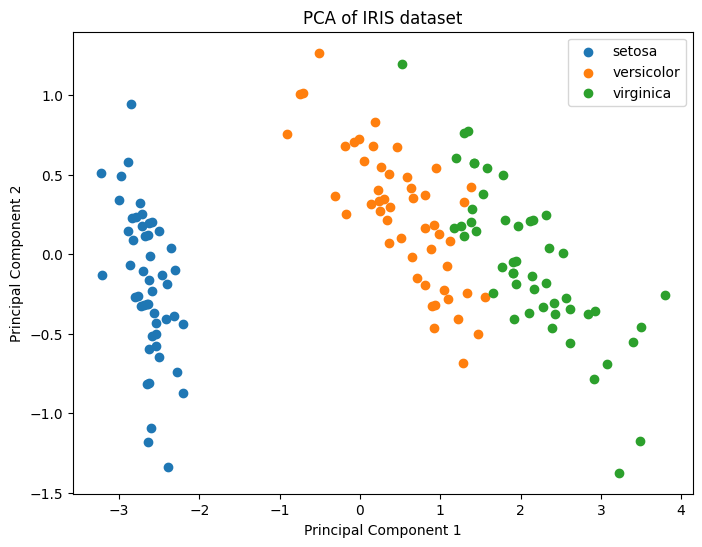

In [17]:
# Plot the features outputted by PCA
plt.figure(figsize=(8, 6))
for target in set(y):
    plt.scatter(new_data[y == target, 0], new_data[y == target, 1], label=iris.target_names[target])

plt.title('PCA of IRIS dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Make eigenvectors' values that are largest in absolute value to be positive

to match results with Sklearn PCA

In [18]:
max_abs_idx = np.argmax(np.abs(eigen_vecs), axis=0)
signs = np.sign(eigen_vecs[max_abs_idx, range(eigen_vecs.shape[1])])
eigen_vecs = eigen_vecs * signs[np.newaxis, :]

In [19]:
X_PCA_projected = x_hat @ eigen_vecs

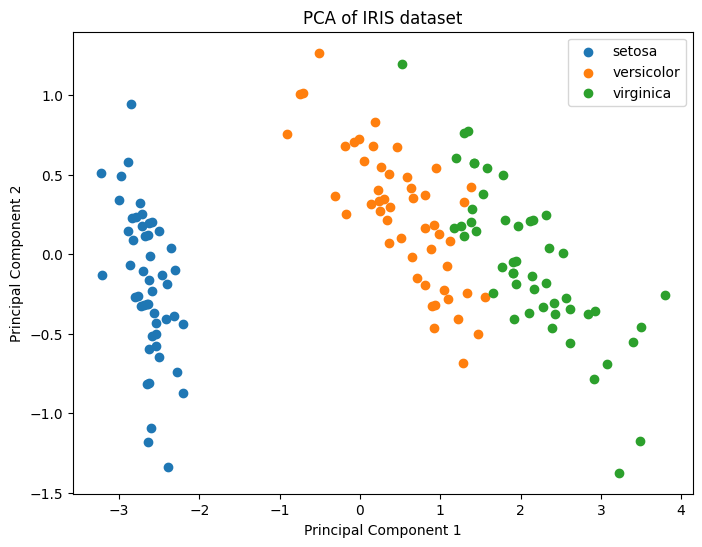

In [20]:
# Plot the features outputted by PCA
plt.figure(figsize=(8, 6))
for target in set(y):
    plt.scatter(new_data[y == target, 0], new_data[y == target, 1], label=iris.target_names[target])

plt.title('PCA of IRIS dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## LDA  
### (Not finished)

In [21]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        total_data = X.shape[0]
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            n_c = X_c.shape[0]
            SW += (X_c - mean_c).T.dot((X_c - mean_c)) * n_c / total_data 
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += (mean_diff).dot(mean_diff.T) * n_c / total_data

        # Determine SW^-1 * SB
        A = np.linalg.inv(SW).dot(SB)
        # Get eigenvalues and eigenvectors of SW^-1 * SB
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvalues high to low
        eigenvectors = eigenvectors.T
        idxs = np.argsort(abs(eigenvalues))[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        # store first n eigenvectors
        self.linear_discriminants = eigenvectors[0 : self.n_components]

    def transform(self, X):
        # project data
        return np.dot(X, self.linear_discriminants.T)


In [22]:
X.shape

(150, 4)

In [23]:
# Project the data onto the 2 primary linear discriminants
lda = LDA(2)
lda.fit(X, y)
X_LDA_projected = lda.transform(X)

In [24]:
print("Shape of X:", X.shape)
print("Shape of transformed X:", X_LDA_projected.shape)

Shape of X: (150, 4)
Shape of transformed X: (150, 2)


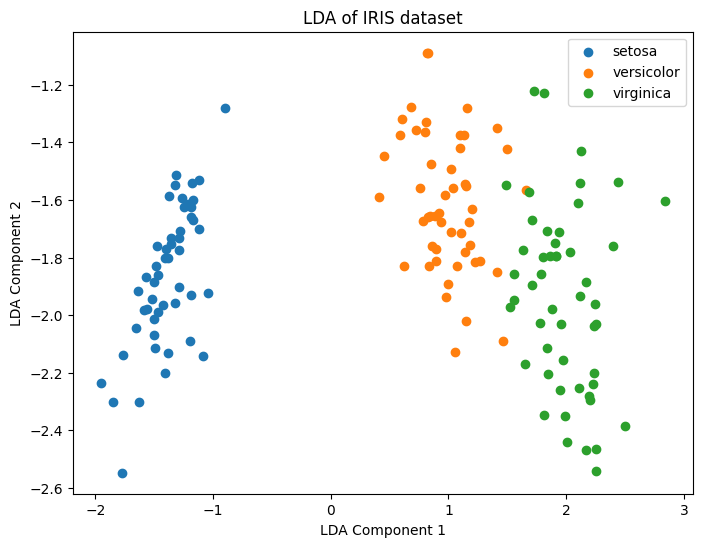

In [25]:
# Plot the features outputted by PCA
plt.figure(figsize=(8, 6))
for target in set(y):
    plt.scatter(X_LDA_projected[y == target, 0], X_LDA_projected[y == target, 1], label=iris.target_names[target])

plt.title('LDA of IRIS dataset')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend()
plt.show()

# KNN Clustering results